In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error,
    accuracy_score, classification_report, confusion_matrix
)

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [3]:
crop_recommendation = pd.read_csv("/content/Crop_recommendation.csv")

crop_production = pd.read_csv("/content/crop_production.csv")

rainfall_data = pd.read_csv("/content/district wise rainfall normal.csv")

In [4]:
print("\n--- Crop Recommendation Dataset Info ---")
print(crop_recommendation.info())

print("\n--- Crop Production Dataset Info ---")
print(crop_production.info())

print("\n--- Rainfall Data Info ---")
print(rainfall_data.info())


--- Crop Recommendation Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None

--- Crop Production Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246091 entries, 0 to 246090
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   State_Name     246091 non-null  object 
 1   District_Name  246091 non-null  object 
 2   Crop_Year      246091 non-null

In [5]:
print("\n--- Crop Recommendation Dataset Description ---")
print(crop_recommendation.describe())

print("\n--- Crop Production Dataset Description ---")
print(crop_production.describe())

print("\n--- Rainfall Data Description ---")
print(rainfall_data.describe())



--- Crop Recommendation Dataset Description ---
                 N            P            K  temperature     humidity           ph     rainfall
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000
mean     50.551818    53.362727    48.149091    25.616244    71.481779     6.469480   103.463655
std      36.917334    32.985883    50.647931     5.063749    22.263812     0.773938    54.958389
min       0.000000     5.000000     5.000000     8.825675    14.258040     3.504752    20.211267
25%      21.000000    28.000000    20.000000    22.769375    60.261953     5.971693    64.551686
50%      37.000000    51.000000    32.000000    25.598693    80.473146     6.425045    94.867624
75%      84.250000    68.000000    49.000000    28.561654    89.948771     6.923643   124.267508
max     140.000000   145.000000   205.000000    43.675493    99.981876     9.935091   298.560117

--- Crop Production Dataset Description ---
           Crop_Year          Are

In [6]:
crop_production.dropna(subset=['Production'], inplace=True)
print(crop_production.isnull().sum())

State_Name       0
District_Name    0
Crop_Year        0
Season           0
Crop             0
Area             0
Production       0
dtype: int64


In [7]:
def missing_summary(df, name):
    """Print missing values and their percentages for each dataset."""
    missing_count = df.isnull().sum()
    missing_percentage = (missing_count / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Values': missing_count, 'Missing %': missing_percentage})
    print(f"\n--- Missing Values in {name} ---")
    print(missing_df[missing_df['Missing Values'] > 0])

missing_summary(crop_recommendation, "Crop Recommendation")
missing_summary(crop_production, "Crop Production")
missing_summary(rainfall_data, "Rainfall Data")


--- Missing Values in Crop Recommendation ---
Empty DataFrame
Columns: [Missing Values, Missing %]
Index: []

--- Missing Values in Crop Production ---
Empty DataFrame
Columns: [Missing Values, Missing %]
Index: []

--- Missing Values in Rainfall Data ---
Empty DataFrame
Columns: [Missing Values, Missing %]
Index: []


In [8]:
print("\nDuplicates in Crop Recommendation:", crop_recommendation.duplicated().sum())
print("Duplicates in Crop Production:", crop_production.duplicated().sum())
print("Duplicates in Rainfall Data:", rainfall_data.duplicated().sum())

crop_recommendation.drop_duplicates(inplace=True)
crop_production.drop_duplicates(inplace=True)
rainfall_data.drop_duplicates(inplace=True)


Duplicates in Crop Recommendation: 0
Duplicates in Crop Production: 0
Duplicates in Rainfall Data: 0


In [9]:
print(rainfall_data.columns.tolist())

['STATE_UT_NAME', 'DISTRICT', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANNUAL', 'Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']


In [10]:
# --- FEATURE SELECTION ---
crop_recommendation_selected = crop_recommendation[['N','P','K','temperature','humidity','ph','rainfall','label']]
crop_production_selected = crop_production[['Crop_Year','Season','Crop','Area','Production']]
rainfall_selected = rainfall_data[['STATE_UT_NAME', 'DISTRICT', 'ANNUAL',
                                   'Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']]

In [11]:
label_encoder = LabelEncoder()
crop_recommendation_selected['Encoded_label'] = label_encoder.fit_transform(crop_recommendation_selected['label'])
crop_production_encoded = pd.get_dummies(crop_production_selected, columns=['Season','Crop'], drop_first=True)

In [12]:
print("\nCrop Recommendation (after selection & encoding):")
print(crop_recommendation_selected.head())

print("\nCrop Production (after encoding):")
print(crop_production_encoded.head())

print("\nRainfall Data (for drought/flood):")
print(rainfall_selected.head())


Crop Recommendation (after selection & encoding):
    N   P   K  temperature   humidity        ph    rainfall label  Encoded_label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice             20
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice             20
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice             20
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice             20
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice             20

Crop Production (after encoding):
   Crop_Year    Area  Production  Season_Kharif       Season_Rabi         Season_Summer       Season_Whole Year   Season_Winter       Crop_Arcanut (Processed)  Crop_Arecanut  Crop_Arhar/Tur  Crop_Ash Gourd  Crop_Atcanut (Raw)  Crop_Bajra  Crop_Banana  Crop_Barley  Crop_Bean  Crop_Beans & Mutter(Vegetable)  Crop_Beet Root  Crop_Ber  Crop_Bhindi  Crop_Bitter Gourd  Crop_Black pepper  Crop_Blackgram  Crop_Bottle Gourd  Crop_Bri

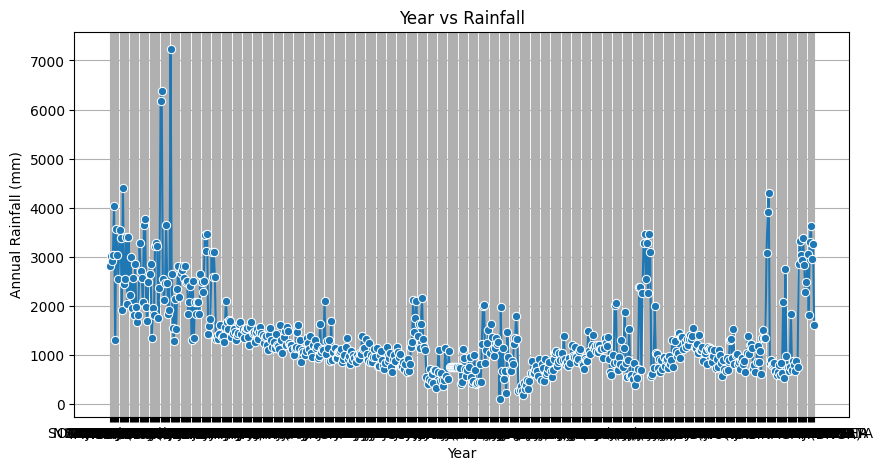

In [13]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=rainfall_selected, x="DISTRICT", y="ANNUAL", marker="o")
plt.title("Year vs Rainfall")
plt.xlabel("Year")
plt.ylabel("Annual Rainfall (mm)")
plt.grid(True)
plt.show()

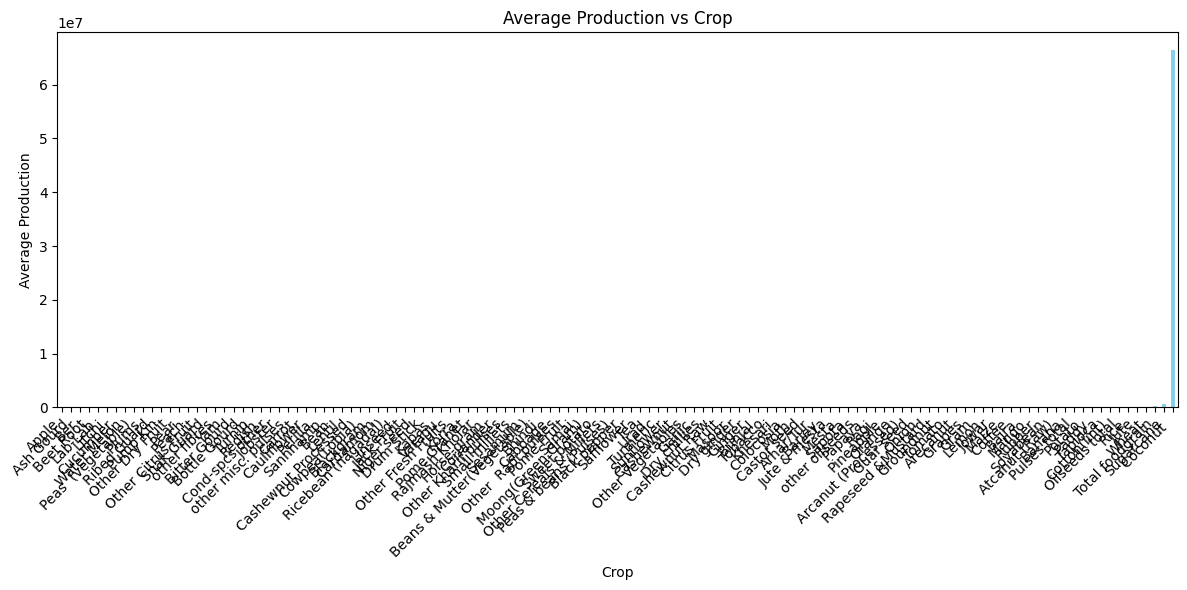

In [14]:
avg_production_crop = crop_production.groupby("Crop")["Production"].mean().sort_values()
plt.figure(figsize=(12, 6))
avg_production_crop.plot(kind="bar", color="skyblue")
plt.title("Average Production vs Crop")
plt.ylabel("Average Production")
plt.xlabel("Crop")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

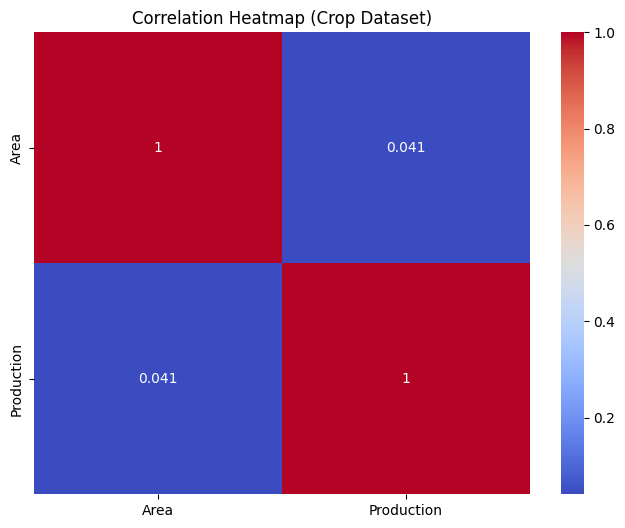

In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(crop_production[["Area", "Production"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Crop Dataset)")
plt.show()

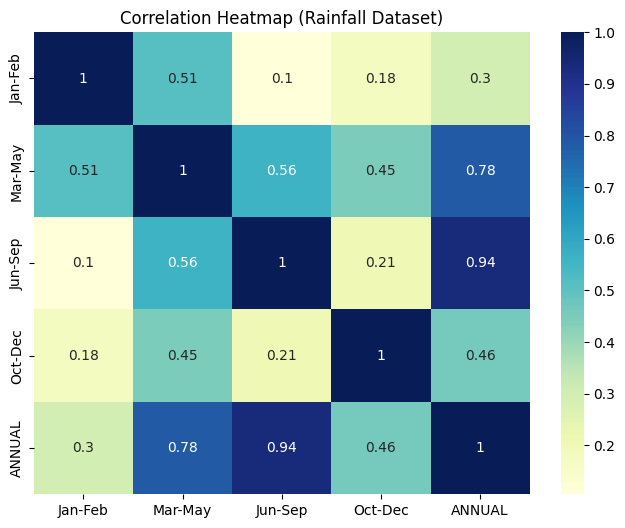

In [16]:
plt.figure(figsize=(8, 6))
rainfall_corr = rainfall_selected[["Jan-Feb", "Mar-May", "Jun-Sep", "Oct-Dec", "ANNUAL"]].corr()
sns.heatmap(rainfall_corr, annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap (Rainfall Dataset)")
plt.show()

In [17]:
from sklearn.preprocessing import LabelEncoder

# Create encoders
state_encoder = LabelEncoder()
district_encoder = LabelEncoder()

# Apply encoding to rainfall_selected
rainfall_selected['STATE_UT_NAME'] = state_encoder.fit_transform(rainfall_selected['STATE_UT_NAME'])
rainfall_selected['DISTRICT'] = district_encoder.fit_transform(rainfall_selected['DISTRICT'])


In [18]:
X = rainfall_selected.drop(columns=['ANNUAL'])
y = rainfall_selected['ANNUAL']


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)